# Face Mask Detection using Transfer Learning

    With the Covid-19 Pandemic, wearing of the face masks have become mandatory across the globe. Thus, an AI application 
    that would enable the automatic detection if a person is wearing mask / or not will be beneficial in areas such as 
    auto-controlled (unmanned) entry gates at various places. A camera based application could flag-off persons not wearing
    mask and thus not allowing entry.

### Import Utilities and Packages

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# Import the pre-trained models
# from efficientnet.tfkeras import EfficientNetB0, EfficientNetB4
# from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input

import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import random as rn

from DataUtility import dataUtils
dUtils = dataUtils()

from DataUtility import IMAGE_AUGMENTATION_TYPE
from DataUtility import FACE_MASK_TYPE

Using TensorFlow backend.


### Read the Data / Images

#### Masked Faces

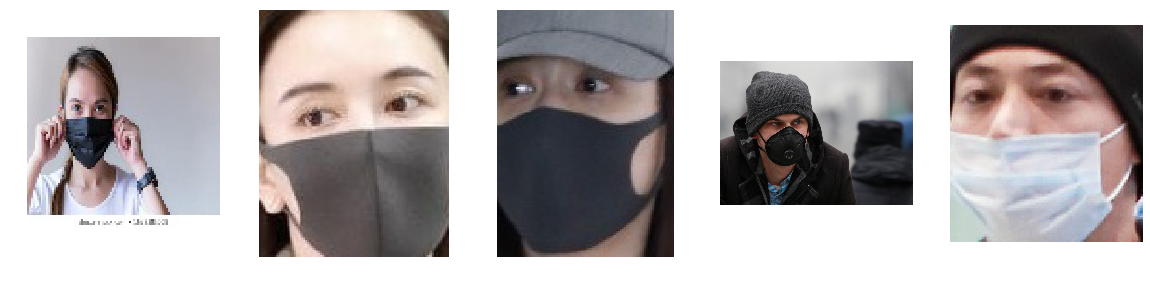

In [2]:
dUtils.ReadAndDisplayInputImages(FACE_MASK_TYPE.MASKED.value, 5)

#### Un-Masked Faces

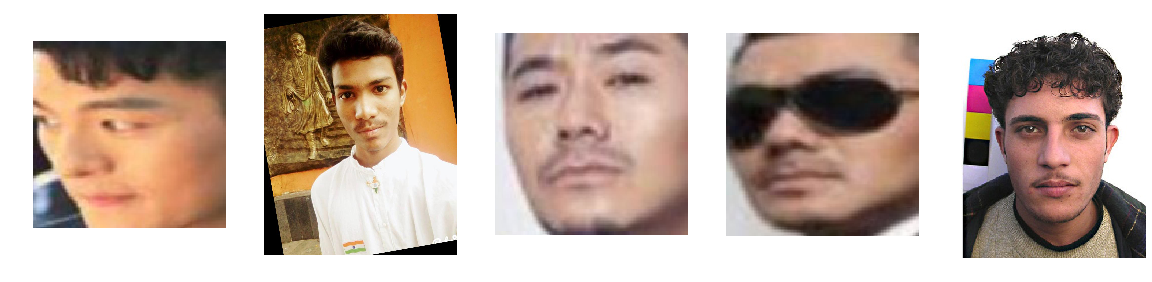

In [3]:
dUtils.ReadAndDisplayInputImages(FACE_MASK_TYPE.NON_MASKED.value, 5)

### Labelled Dataset

In [4]:
face_masked_df = dUtils.GetLabelledFaceMaskData()

dUtils.PrintMarkdownText('***Labelled Face Mask Data...***')
face_masked_df.head()

<br>

***Labelled Face Mask Data...***

,filename,label
0,facial-images/with_mask/0_0_7 copy.jpg,Masked
1,facial-images/with_mask/pexels-photo-3869389.jpeg,Masked
2,facial-images/with_mask/1_0_0 copy 4.jpg,Masked
3,facial-images/with_mask/1_0_25.jpg,Masked
4,facial-images/with_mask/with_mask154.jpg,Masked


<br>

***Sample Annotated MASKED & NON_MASKED Images...***

/mnt/disks/user/project/Face_Mask_Detector/DataUtility.py:291: FutureWarning: `item` has been deprecated and will be removed in a future version
  plt.title(labels[i].item())


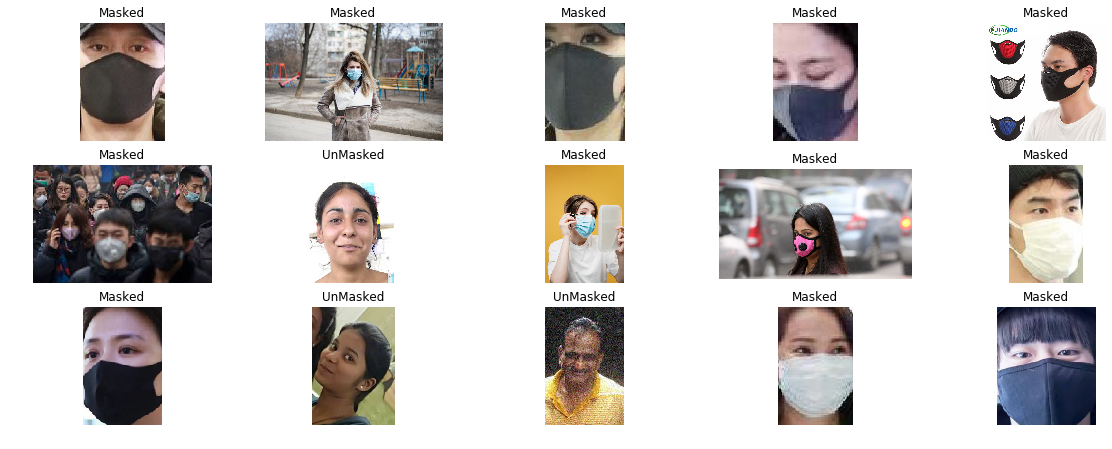

In [5]:
dUtils.PrintMarkdownText('***Sample Annotated MASKED & NON_MASKED Images...***')
dUtils.DisplayAnnotatedImages(face_masked_df, 15)

### Prepare Images for Training

In [6]:
images = []
labels = []

# loop the image collection and process the images
for idx in range(0, len(face_masked_df)):

    # load the image and apply NasNet defined pre-processing
    # https://keras.io/api/applications/nasnet/
    
    img = face_masked_df.filename[idx]
    image = load_img(img, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the master lists for images and labels.
    images.append(image)
    labels.append(face_masked_df.label[idx])

# convert the data and labels to NumPy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [7]:
# Convert the labels into the binary format.
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Test-Train Split

In [8]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size=0.20, stratify=labels, random_state=42)

### Model Training Parameters

In [10]:
BATCH_SIZE = 16
NUM_CLASSES = 2
EPOCHS = 30
INPUT_SHAPE = (224, 224, 3)

### Data Augmentation

In [11]:
train_data_augmentor = ImageDataGenerator(rotation_range=20,
                                          zoom_range=0.15,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.15,
                                          horizontal_flip=True,
                                          fill_mode="nearest")

train_gen = train_data_augmentor.flow(X_train, y_train, batch_size = BATCH_SIZE, shuffle=True)

### Model Creation

In [12]:
# model creation using the pre-trained model
preTrained = NASNetMobile(weights = "imagenet", include_top = False, input_tensor = Input(shape = INPUT_SHAPE))

model = preTrained.output
model = AveragePooling2D(pool_size = (5, 5))(model)
model = Flatten(name = "flatten")(model)
model = Dense(128, activation = "relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation = "softmax")(model)

model = Model(inputs = preTrained.input, outputs = model, name = "face_mask_detector_pretrained")

# freeze the initial layers of the NASNetMobile
# model such that they do not train again.
for layer in preTrained.layers:
    layer.trainable = False

# model compilation
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

19996672/19993432 [==============================] - 1s 0us/step


### Model Checkpoints

In [13]:
filepath = './' + model.name + '.h5'
print("Model Checkpoint (.h5 file) Path:", filepath)

Model_Check_Point = ModelCheckpoint(filepath, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = False, 
                             mode = 'auto', 
                             save_freq = 'epoch')

Learning_Rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1)
Early_Stop = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, mode = 'auto')

callback_list = [Model_Check_Point]

Model Checkpoint (.h5 file) Path: ./face_mask_detector_pretrained.h5


### Model Fit

In [14]:
train_history = model.fit(train_gen,
                          steps_per_epoch=len(X_train) // BATCH_SIZE,
                          validation_data=(X_test, y_test),
                          validation_steps=len(X_test) // BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/30
195/195 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9506

W1001 10:50:18.034372 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00001: val_loss improved from inf to 0.03170, saving model to ./face_mask_detector_pretrained.h5
195/195 [==============================] - 46s 234ms/step - loss: 0.1292 - accuracy: 0.9506 - val_loss: 0.0317 - val_accuracy: 0.9859
Epoch 2/30
195/195 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9729

W1001 10:50:57.916458 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00002: val_loss improved from 0.03170 to 0.02070, saving model to ./face_mask_detector_pretrained.h5
195/195 [==============================] - 40s 203ms/step - loss: 0.0760 - accuracy: 0.9729 - val_loss: 0.0207 - val_accuracy: 0.9936
Epoch 3/30
195/195 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9755

W1001 10:51:37.164705 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00003: val_loss did not improve from 0.02070
195/195 [==============================] - 38s 194ms/step - loss: 0.0672 - accuracy: 0.9755 - val_loss: 0.0288 - val_accuracy: 0.9872
Epoch 4/30
195/195 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9781

W1001 10:52:14.583728 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00004: val_loss did not improve from 0.02070
195/195 [==============================] - 37s 191ms/step - loss: 0.0592 - accuracy: 0.9781 - val_loss: 0.0212 - val_accuracy: 0.9885
Epoch 5/30
195/195 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9826

W1001 10:52:52.010350 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00005: val_loss did not improve from 0.02070
195/195 [==============================] - 37s 191ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.0240 - val_accuracy: 0.9885
Epoch 6/30
195/195 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9816

W1001 10:53:30.272161 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00006: val_loss did not improve from 0.02070
195/195 [==============================] - 38s 196ms/step - loss: 0.0501 - accuracy: 0.9816 - val_loss: 0.0273 - val_accuracy: 0.9910
Epoch 7/30
195/195 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9855

W1001 10:54:07.803693 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00007: val_loss did not improve from 0.02070
195/195 [==============================] - 37s 192ms/step - loss: 0.0413 - accuracy: 0.9855 - val_loss: 0.0296 - val_accuracy: 0.9872
Epoch 8/30
195/195 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9791

W1001 10:54:45.310757 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00008: val_loss improved from 0.02070 to 0.01640, saving model to ./face_mask_detector_pretrained.h5
195/195 [==============================] - 39s 199ms/step - loss: 0.0559 - accuracy: 0.9791 - val_loss: 0.0164 - val_accuracy: 0.9949
Epoch 9/30
195/195 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9907

W1001 10:55:24.931843 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00009: val_loss did not improve from 0.01640
195/195 [==============================] - 38s 195ms/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 0.0182 - val_accuracy: 0.9910
Epoch 10/30
195/195 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9868

W1001 10:56:02.331489 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00010: val_loss did not improve from 0.01640
195/195 [==============================] - 37s 191ms/step - loss: 0.0417 - accuracy: 0.9868 - val_loss: 0.0164 - val_accuracy: 0.9923
Epoch 11/30
195/195 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9903

W1001 10:56:39.846927 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00011: val_loss did not improve from 0.01640
195/195 [==============================] - 37s 192ms/step - loss: 0.0350 - accuracy: 0.9903 - val_loss: 0.0164 - val_accuracy: 0.9923
Epoch 12/30
195/195 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9865

W1001 10:57:17.075995 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00012: val_loss did not improve from 0.01640
195/195 [==============================] - 37s 190ms/step - loss: 0.0409 - accuracy: 0.9865 - val_loss: 0.0187 - val_accuracy: 0.9910
Epoch 13/30
195/195 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9845

W1001 10:57:55.214265 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00013: val_loss did not improve from 0.01640
195/195 [==============================] - 38s 195ms/step - loss: 0.0431 - accuracy: 0.9845 - val_loss: 0.0172 - val_accuracy: 0.9898
Epoch 14/30
195/195 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9858

W1001 10:58:32.602516 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00014: val_loss did not improve from 0.01640
195/195 [==============================] - 37s 191ms/step - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.0238 - val_accuracy: 0.9885
Epoch 15/30
195/195 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9890

W1001 10:59:09.760345 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00015: val_loss did not improve from 0.01640
195/195 [==============================] - 37s 190ms/step - loss: 0.0361 - accuracy: 0.9890 - val_loss: 0.0173 - val_accuracy: 0.9910
Epoch 16/30
195/195 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9862

W1001 10:59:47.599421 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00016: val_loss improved from 0.01640 to 0.01163, saving model to ./face_mask_detector_pretrained.h5
195/195 [==============================] - 39s 201ms/step - loss: 0.0397 - accuracy: 0.9862 - val_loss: 0.0116 - val_accuracy: 0.9974
Epoch 17/30
195/195 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9890

W1001 11:00:27.003746 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00017: val_loss did not improve from 0.01163
195/195 [==============================] - 38s 194ms/step - loss: 0.0319 - accuracy: 0.9890 - val_loss: 0.0153 - val_accuracy: 0.9910
Epoch 18/30
195/195 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9868

W1001 11:01:04.280350 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00018: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 191ms/step - loss: 0.0352 - accuracy: 0.9868 - val_loss: 0.0257 - val_accuracy: 0.9885
Epoch 19/30
195/195 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9871

W1001 11:01:42.143680 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00019: val_loss did not improve from 0.01163
195/195 [==============================] - 38s 194ms/step - loss: 0.0336 - accuracy: 0.9871 - val_loss: 0.0202 - val_accuracy: 0.9923
Epoch 20/30
195/195 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9836

W1001 11:02:19.082304 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00020: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 189ms/step - loss: 0.0544 - accuracy: 0.9836 - val_loss: 0.0160 - val_accuracy: 0.9949
Epoch 21/30
195/195 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9916

W1001 11:02:56.296735 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00021: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 190ms/step - loss: 0.0310 - accuracy: 0.9916 - val_loss: 0.0243 - val_accuracy: 0.9910
Epoch 22/30
195/195 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9887

W1001 11:03:33.833525 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00022: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 192ms/step - loss: 0.0290 - accuracy: 0.9887 - val_loss: 0.0392 - val_accuracy: 0.9898
Epoch 23/30
195/195 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9890

W1001 11:04:11.159990 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00023: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 191ms/step - loss: 0.0316 - accuracy: 0.9890 - val_loss: 0.0200 - val_accuracy: 0.9910
Epoch 24/30
195/195 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9894

W1001 11:04:48.086403 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00024: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 189ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.0164 - val_accuracy: 0.9936
Epoch 25/30
195/195 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9858

W1001 11:05:24.588969 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00025: val_loss did not improve from 0.01163
195/195 [==============================] - 36s 187ms/step - loss: 0.0376 - accuracy: 0.9858 - val_loss: 0.0125 - val_accuracy: 0.9949
Epoch 26/30
195/195 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9923

W1001 11:06:01.411905 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00026: val_loss did not improve from 0.01163
195/195 [==============================] - 37s 188ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0161 - val_accuracy: 0.9936
Epoch 27/30
195/195 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9919

W1001 11:06:38.774038 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00027: val_loss improved from 0.01163 to 0.01151, saving model to ./face_mask_detector_pretrained.h5
195/195 [==============================] - 39s 199ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0115 - val_accuracy: 0.9949
Epoch 28/30
195/195 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9907

W1001 11:07:17.507249 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00028: val_loss did not improve from 0.01151
195/195 [==============================] - 37s 191ms/step - loss: 0.0326 - accuracy: 0.9907 - val_loss: 0.0130 - val_accuracy: 0.9923
Epoch 29/30
195/195 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9897

W1001 11:07:54.539523 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00029: val_loss did not improve from 0.01151
195/195 [==============================] - 37s 189ms/step - loss: 0.0283 - accuracy: 0.9897 - val_loss: 0.0154 - val_accuracy: 0.9910
Epoch 30/30
195/195 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9910

W1001 11:08:32.525042 139652114708288 data_adapter.py:1153] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 48 batches). You may need to use the repeat() function when building your dataset.



Epoch 00030: val_loss improved from 0.01151 to 0.01124, saving model to ./face_mask_detector_pretrained.h5
195/195 [==============================] - 39s 201ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0112 - val_accuracy: 0.9962


### Deploy the model to local Web Cam for Live Mask Detection

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

model = load_model('face_mask_detector_pretrained.h5')

video_capture = cv2.VideoCapture(0)

while True:
    ret,frame =video_capture.read() 
    res_frame = cv2.resize(frame, (frame.shape[1] // 4, frame.shape[0] //4))
    faces = face_cascade.detectMultiScale(res_frame)
    for f in faces:
        (x, y, w, h) = [v * 4 for v in f] 
        face_img = frame[y:y+h, x:x+w]
        resized = cv2.resize(face_img,(224,224))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result = model.predict(reshaped)
        result = np.argmax(result, axis=1)
        print(result)
        if result >= 0.8:
            prediction = 'Without Mask'
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
            cv2.putText(frame, prediction, (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,255),2)
        else:
            prediction = 'With Mask'
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(frame, prediction, (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
        
    
    cv2.imshow('Face_Mask_Detector', frame)

    if cv2.waitKey(1) == 27:
        break
    if cv2.getWindowProperty('Face_Mask_Detector',cv2.WND_PROP_VISIBLE) < 1:        
        break

video_capture.release()
cv2.destroyAllWindows()